In [1]:
from linares_plot import *
import sys, os
import statsmodels.formula.api as smf
path_tools = 'C:\\Users\\David\\Documents\\GitHub\\encoding\\scripts\\wm_representation\\functions\\IEM\\tools'
sys.path.insert(1, path_tools)
from timecourse import *
from timecourse_c import *
from scipy import stats
from mlxtend.evaluate import permutation_test

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
### (responded y no responded)
paths_target=[ 'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\IEM_trainT_testT_controlbroca.xlsx']

paths_target_shuff=[ 'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\shuff_IEM_trainT_testT_controlbroca.xlsx']

In [4]:
df_target=[] ##target ha sido entrenado en el delay del distractor y viceversa
df_target_shuff=[]

for PathI in paths_target:
    path_save_signal =PathI
    #
    decoding_item= path_save_signal.split('\\')[-1].split('.')[0].split('_')[2][-1]
    training_item = path_save_signal.split('\\')[-1].split('.')[0].split('_')[1][-1]
    #
    df_x = pd.read_excel(PathI)
    df_x['decoding_item'] = decoding_item
    df_x['training_item'] =training_item
    
    #
    df_target.append(df_x)
    
#
df_target=pd.concat(df_target, axis=0)
df_target['decoding_item'] = df_target['decoding_item'].replace(['T', 'D'], ['target', 'distractor'])
df_target['training_item'] = df_target['training_item'].replace(['T', 'D'], ['target', 'distractor'])


####################

for PathI in paths_target_shuff:
    path_sh_signal =PathI
    #
    decoding_item= path_sh_signal.split('\\')[-1].split('.')[0].split('_')[3][-1]
    training_item = path_sh_signal.split('\\')[-1].split('.')[0].split('_')[2][-1]
    #
    df_x = pd.read_excel(PathI)
    df_x['decoding_item'] = decoding_item
    df_x['training_item'] =training_item
    
    #
    df_target_shuff.append(df_x)
    
#
df_target_shuff=pd.concat(df_target_shuff, axis=0)
df_target_shuff['decoding_item'] = df_target_shuff['decoding_item'].replace(['T', 'D'], ['target', 'distractor'])
df_target_shuff['training_item'] = df_target_shuff['training_item'].replace(['T', 'D'], ['target', 'distractor'])

In [7]:
df.head()

,Unnamed: 0,times,decoding,region,subject,condition,label,decoding_item,training_item
0,0,0.000,-2.587926,broca,d001,1_0.2,signal,target,target
1,1,2.335,-1.139419,broca,d001,1_0.2,signal,target,target
2,2,4.670,0.085520,broca,d001,1_0.2,signal,target,target
3,3,7.005,3.064341,broca,d001,1_0.2,signal,target,target
4,4,9.340,5.918764,broca,d001,1_0.2,signal,target,target


In [5]:
df = df_target
df_shuff = df_target_shuff

df_time_target=[]


for cond in ['1_0.2']:
    for reg in ['broca']:
        for subj in ['d001', 's001', 'l001', 'n001', 'b001', 'r001']:
            for training_item in ['target']:
                for t in df.times.unique(): 
                    #
                    decoding_item='target'
                    #
                    dec_sig = df.loc[(df['region']==reg) & (df['times']== t) & 
                           ( df['condition']==cond) & (df['subject']==subj) &  
                           ( df['training_item']==training_item) & 
                           ( df['decoding_item']== decoding_item)]
                    #
                    dec_shuff = df_shuff.loc[(df_shuff['region']==reg) & (df_shuff['times']== t) & 
                           ( df_shuff['condition']==cond) & (df_shuff['subject']==subj) &  
                           ( df_shuff['training_item']==training_item)  & 
                           ( df_shuff['decoding_item']== decoding_item) ].decoding
                    #
                    #decoding_ = (dec_sig.decoding.iloc[0]  - dec_shuff.mean()) / dec_shuff.std()
                    decoding_ = dec_sig.decoding.iloc[0]  - dec_shuff.mean()
                    pval_shuff = permutation_test([dec_sig.decoding.iloc[0]], list(dec_shuff), method='approximate', num_rounds=1000, seed=0)
                    #
                    df_time_target.append( [t, decoding_, reg, subj, cond, dec_sig.label.iloc[0], training_item, decoding_item, pval_shuff] )   
                    ####)
#
df_time_target = pd.DataFrame(df_time_target)
df_time_target.columns=['times', 'decoding', 'region', 'subject', 'condition', 'label', 'training_item', 'decoding_item', 'pval']

In [18]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



presentation_period= 0.35 #stim presnetation time
presentation_period_cue=  0.50 #presentation of attentional cue time
pre_stim_period= 0.5 #time between cue and stim
resp_time = 4  #time the response is active


def tiemcourse_c_broca(df_plot, title_plot, decoding_thing='target', ylims=[-20,20]):
    ##
    ###
    ####   In the input dataframe you need the following columns:
    ###  'new_mean', 'inf', 'sup', 'brain_reg', 'time', 'condition'
    ## 
    pal = ['darkblue'] #sns.color_palette("tab10", n_colors=12, desat=1).as_hex()[0:3]
    ##
    fig = plt.figure(figsize=(12,10))
    for indx_c, condition in enumerate(['1_0.2', '1_7', '2_0.2', '2_7']): 
        #features of the plot for the different conditions. Fixed values
        if condition == '1_0.2':
            condition_title = 'order 1; TDOA 0.2s'
            #y_label_cond = 'decoding ' + decoding_thing + ' (std)'
            y_label_cond = decoding_thing + ' decoding '   #+ ' (signal-shuff)'
            x_label_cond = ''
            delay1 = 0.2
            delay2 = 11.8
            cue=0
            t_p = cue + presentation_period_cue + pre_stim_period 
            d_p = t_p + presentation_period +delay1 
            r_t = d_p + presentation_period + delay2
            xlim = [1, 25]

        elif condition == '1_7':
            condition_title = 'order 1; TDOA 7s'
            y_label_cond = '' 
            x_label_cond = ''
            delay1 = 7
            delay2 = 5
            cue=0
            t_p = cue + presentation_period_cue + pre_stim_period 
            d_p = t_p + presentation_period +delay1 
            r_t = d_p + presentation_period + delay2
            xlim = [1, 25]

        elif condition == '2_0.2':
            condition_title = 'order 2; TDOA 0.2s'
            #y_label_cond = 'decoding ' + decoding_thing + ' (std)'
            y_label_cond = decoding_thing  + ' decoding '  #+ ' (signal-shuff)'
            x_label_cond = 'time (s)'        
            delay1 = 0.2
            delay2 = 12
            cue=0
            d_p = cue + presentation_period_cue + pre_stim_period 
            t_p = d_p + presentation_period +delay1 
            r_t = t_p + presentation_period + delay2   
            xlim = [1, 25]

        elif condition == '2_7':
            condition_title = 'order 2; TDOA 7s'
            y_label_cond = '' 
            x_label_cond = 'time (s)' 
            delay1 = 7
            delay2 = 12
            cue=0
            d_p = cue + presentation_period_cue + pre_stim_period 
            t_p = d_p + presentation_period +delay1 
            r_t = t_p + presentation_period + delay2
            xlim = [1, 30]


        start_hrf = 4 #start of the Hemodynamic response (4seconds)
        sec_hdrf = 3 #time it can last

        d_p1 = (start_hrf + d_p) ##strat of didtractor (time)
        t_p1 = (start_hrf +t_p) ## strat of target (time)
        r_t1=  (start_hrf + r_t) ## start of response (time)
        #
        d_p2 = d_p1 + sec_hdrf # end of distractor (time)
        t_p2 = t_p1 + sec_hdrf # end of target (time)
        r_t2=  r_t1 + sec_hdrf + resp_time #end of response (time)

        y_vl_min = -10 #df_all_by_subj.Decoding.min() #values min and max
        y_vl_max = 10 #◙df_all_by_subj.Decoding.max()

        #fig = plt.figure()
        ax = fig.add_subplot(2,2, indx_c+1) 
        
        data_cond = df_plot.loc[df_plot['condition']==condition ]
        sns.lineplot( ax=ax, x="times", y="decoding", hue='region', ci=95,
                     hue_order =  ['broca'], palette=pal, data=data_cond)
        plt.plot([0, 35], [0,0], 'k--', linewidth=1)   ## plot chance level (0)
        plt.fill_between(  [ t_p1, t_p2 ], [y_vl_min, y_vl_min], [y_vl_max, y_vl_max], color='grey', alpha=0.3) #, label='target'  ) #plot aprox time of target
        plt.fill_between(  [ d_p1, d_p2 ], [y_vl_min, y_vl_min], [y_vl_max, y_vl_max], color='darkred', alpha=0.3) #, label='distractor'  ) #plot aprox time of distractor
        plt.fill_between(  [ r_t1, r_t2 ], [y_vl_min, y_vl_min], [y_vl_max, y_vl_max], color='y', alpha=0.3) #, label='response'  )   #plot aprox time of response
        #
        TITLE_BR = condition_title 
        plt.title(TITLE_BR, fontsize=20) #condition title
        plt.gca().spines['right'].set_visible(False) #no right axis
        plt.gca().spines['top'].set_visible(False) #no  top axis
        plt.gca().get_xaxis().tick_bottom()
        plt.gca().get_yaxis().tick_left()
        plt.xticks([5,10,15,20,25,30,35], fontsize=15) #just this tcks
        plt.ylim(ylims[0], ylims[1])
        if ylims[0]==-10:
            plt.yticks([-10, -5, 0 , 5, 10], fontsize=15)
        if ylims[0]==-20:
            plt.yticks([-20, -10, 0 , 10, 20], fontsize=15)
        if ylims[0]==-30:
            plt.yticks([-30, -15, 0 , 15, 30], fontsize=15)
        if ylims[0]==-40:
            plt.yticks([-40, -20, 0 , 20, 40], fontsize=15)
        if ylims[0]==-50:
            plt.yticks([-50, -25, 0 , 25, 50], fontsize=15)
        if ylims[0]==-60:
            plt.yticks([-60, -30, 0 , 30, 60], fontsize=15)
        #
        plt.xlim(xlim)
        plt.xlabel(x_label_cond, fontsize=20)
        plt.ylabel(y_label_cond, fontsize=20)
        if indx_c==3: #legend in just this condition (to avoid repetitions)       
            plt.gca().legend(loc=1, frameon=False, bbox_to_anchor=(1.1, 1.05), fontsize=15)
            plt.xticks([5,10, 15, 20, 25,30], fontsize=15)

        else:
            plt.gca().legend(loc= 1, frameon=False).remove()



    ##
    plt.suptitle( title_plot, fontsize=25) ## main title
    plt.tight_layout(w_pad=1, h_pad=1, rect=[0, 0.03, 1, 0.95]) #correct the space between graphs
    #plt.show(block=False) #show
    
    
    

    
    

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


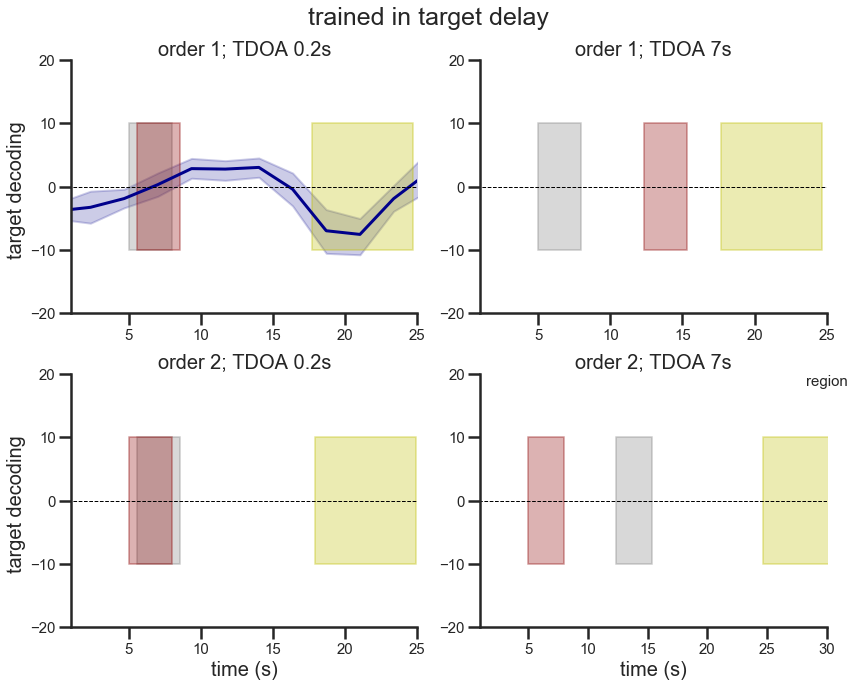

In [19]:
df_x = df_time_target.loc[df_time_target['training_item']=='target']
tiemcourse_c_broca(df_x , 'trained in target delay', ylims=[-20,20])


In [11]:
df_x

,times,decoding,region,subject,condition,label,training_item,decoding_item,pval
0,0.000,-1.436252,broca,d001,1_0.2,signal,target,target,0.021
1,2.335,-0.674136,broca,d001,1_0.2,signal,target,target,0.000
2,4.670,-0.163231,broca,d001,1_0.2,signal,target,target,0.613
3,7.005,2.537523,broca,d001,1_0.2,signal,target,target,0.000
4,9.340,5.244569,broca,d001,1_0.2,signal,target,target,0.000
...,...,...,...,...,...,...,...,...,...
91,25.685,0.864424,broca,r001,1_0.2,signal,target,target,0.000
92,28.020,2.433315,broca,r001,1_0.2,signal,target,target,0.000
93,30.355,4.573298,broca,r001,1_0.2,signal,target,target,0.000
94,32.690,4.930310,broca,r001,1_0.2,signal,target,target,0.000
